In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wn
wn.filterwarnings('ignore')

In [15]:
data=pd.read_csv(r'D:\python_codes\UCI_Credit_Card.csv')
df=data.copy()

In [16]:
df.rename(columns={
    "default.payment.next.month": "default"
}, inplace=True)

In [17]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [18]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [20]:
credit_count=df['default'].value_counts()
credit_count

default
0    23364
1     6636
Name: count, dtype: int64

In [21]:
credit_unique=df['default'].unique()

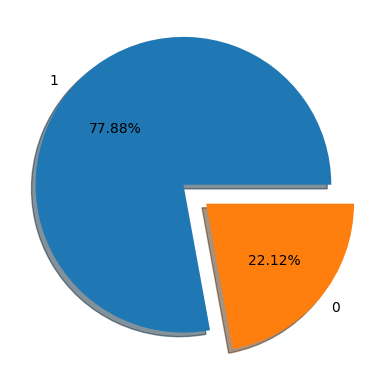

In [22]:
explode = [0.1,0.1]
plt.pie(credit_count,labels=credit_unique,autopct='%.2f%%',explode=explode,shadow=True)
plt.show()

<Axes: >

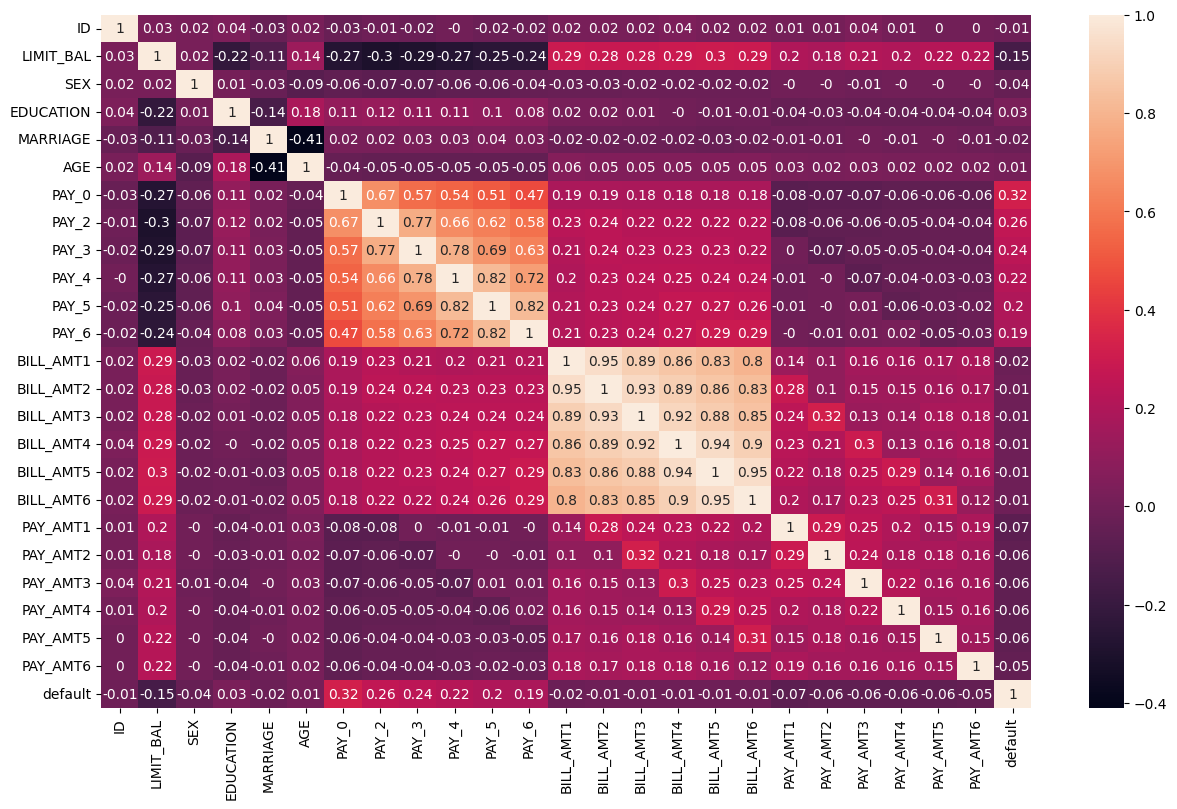

In [23]:
plt.figure(figsize=(15,9))
sns.heatmap(df.corr().round(2),annot=True)

In [24]:
x= df.drop(['ID', 'default'], axis=1)
y=df['default']

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=44)
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [31]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_sampled,y_sampled=smote.fit_resample(x_train,y_train)

In [32]:
# Feature extracting the dataframe by PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x_train_pca=pca.fit_transform(x_sampled)
x_test_pca=pca.transform(x_test)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
models={
    'LogisticRegression':LogisticRegression(),
    'RandomForestClassifier':RandomForestClassifier()
}

In [36]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
for i in range(len(list(models))):
    md=list(models.values())[i]
    md.fit(x_train,y_train)

    y_train_pred=md.predict(x_train)
    y_pred=md.predict(x_test)
    y_train_proba = md.predict_proba(x_train)[:,1]
    y_test_proba = md.predict_proba(x_test)[:,1]

    print('Model : ',list(models.keys())[i])
    print('-------training data--------')
    print('accuracy_score=',accuracy_score(y_train,y_train_pred))
    print('precision_score=',precision_score(y_train,y_train_pred))
    print('recall_score=',recall_score(y_train,y_train_pred))
    print("ROC AUC Score:", roc_auc_score(y_train, y_train_proba)) 
    print()

    print('Model : ',list(models.keys())[i])
    print('-------test data--------')
    print('accuracy_score=',accuracy_score(y_test,y_pred))
    print('precision_score=',precision_score(y_test,y_pred))
    print('recall_score=',recall_score(y_test,y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_test_proba)) 
    print()

Model :  LogisticRegression
-------training data--------
accuracy_score= 0.8097777777777778
precision_score= 0.7125676488274203
recall_score= 0.23761780629637055
ROC AUC Score: 0.7236331334650015

Model :  LogisticRegression
-------test data--------
accuracy_score= 0.8112
precision_score= 0.7219047619047619
recall_score= 0.22983626440266827
ROC AUC Score: 0.7264331256732405

Model :  RandomForestClassifier
-------training data--------
accuracy_score= 0.9993777777777778
precision_score= 0.9987963891675025
recall_score= 0.998395829155805
ROC AUC Score: 0.9999959639252085

Model :  RandomForestClassifier
-------test data--------
accuracy_score= 0.8174666666666667
precision_score= 0.648936170212766
recall_score= 0.3699211643420255
ROC AUC Score: 0.7618228871223831



By above model training output by randomforest algorithm, the accuracy_score, ROC AUC Score are good and, precision_score is moderate and  recall_score is low. So,now apply the Hyperparameter tunning to get good accuracy.

In [37]:
rf_params={
    'max_depth':[10,20,44,100,1000],
    'max_features':['auto',10,5,3],
    'max_leaf_nodes':[10,26,44,100,105],
    'min_samples_split':[5,12,19,35],
    'n_estimators':[10,100,1000],
}

In [38]:
randomcv_model=[
    ('RF',RandomForestClassifier(),rf_params), 
]

In [39]:
from sklearn.model_selection import RandomizedSearchCV
model_params={}
for name, model, params in randomcv_model:
    random=RandomizedSearchCV(estimator=model,param_distributions=params,cv=3,verbose=5,n_iter=100,n_jobs=-1)
    random.fit(x_sampled,y_sampled)
    model_params[name]=random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
for model_name in model_params:
    print(f' best params for {model_name}')
    print(model_params[model_name])
    print()